In [2]:
import rioxarray
import geopandas
import leafmap
import os
import datetime
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import rasterio

/usr/local/lib/python3.9/dist-packages/xarray/backends/cfgrib_.py:29: UserWarning: Failed to load cfgrib - most likely there is a problem accessing the ecCodes library. Try `import cfgrib` to get the full error message
  warnings.warn(


In [4]:
out_dir = "data/_grace_tiff"
os.makedirs(out_dir, exist_ok=True)
geodf = geopandas.read_file("data/aoi.geojson")
nc = rioxarray.open_rasterio("data/GRCTellus.JPL.200204_202202.GLO.RL06M.MSCNv02CRI.nc", decode_times=False)[0]
grace_start_date = datetime.datetime(2002, 1, 1)


In [50]:
nc = nc.rio.write_crs("EPSG:4326")
print("Extracting tifs...")
df = pd.DataFrame(columns = ["date", "value"])
for lwe in tqdm(nc["lwe_thickness"]):
    #lwe = nc["lwe_thickness"][0]
    lwe = lwe.rio.clip(geodf.geometry.values, geodf.crs, all_touched=True)
    #lwe = lwe.where(lwe>=0)
    lwe = lwe.rio.write_crs("EPSG:4326")

    upscale_factor = 16
    new_width = lwe.rio.width * upscale_factor
    new_height = lwe.rio.height * upscale_factor

    lwe_upsampled = lwe.rio.reproject(
        lwe.rio.crs,
        shape=(new_height, new_width),
    )
    lwe_upsampled
    lwe_datetime = grace_start_date + datetime.timedelta(days=int(lwe.time.values))
    #lwe.rio.to_raster(f"{out_dir}/{lwe_datetime.strftime('%Y-%m-%d')}.tiff")
    lwe_upsampled.values[lwe_upsampled.values < -99990] = np.nan
    mean = lwe_upsampled.mean(skipna=True)
    #masked = lwe.to_masked_array()
    df = df.append({'date': lwe_datetime.strftime('%Y-%m') + "-01", 'value': mean.values}, ignore_index=True)

Extracting tifs...


100%|██████████| 206/206 [00:31<00:00,  6.62it/s]


In [52]:
df.to_pickle("data/grace_df.pickle")

In [51]:
df

,date,value
0,2002-04-01,4.361454842308495
1,2002-05-01,2.9927513831220844
2,2002-08-01,-0.03384604925628912
3,2002-09-01,-2.0399069266606533
4,2002-10-01,-2.1359947778098256
...,...,...
201,2021-10-01,-12.427783376349586
202,2021-11-01,-10.98964275281652
203,2021-12-01,-7.413302826264958
204,2022-01-01,-5.304010680615704


In [71]:
nc = nc.rio.write_crs("EPSG:4326")
df = pd.DataFrame(columns = ["date", "values"])
lwe = nc["lwe_thickness"][0]
lwe = lwe.rio.clip(geodf.geometry.values, geodf.crs, all_touched=True)
#lwe = lwe.where(lwe>=0)
lwe.values[lwe.values < -99990] = np.nan
arr = lwe.to_masked_array()
arr


masked_array(
  data=[[--, 6.828635107805798, 3.127864709559843, 3.127864709559843],
        [6.828635107805798, 6.828635107805798, 3.127864709559843,
         3.127864709559843],
        [--, --, 3.127864709559843, 3.127864709559843]],
  mask=[[ True, False, False, False],
        [False, False, False, False],
        [ True,  True, False, False]],
  fill_value=1e+20)

<AxesSubplot: title={'center': 'time = 7.35e+03 [days since 2002-01-01T00:00:00...'}, xlabel='longitude [degrees_east]', ylabel='latitude [degrees_north]'>

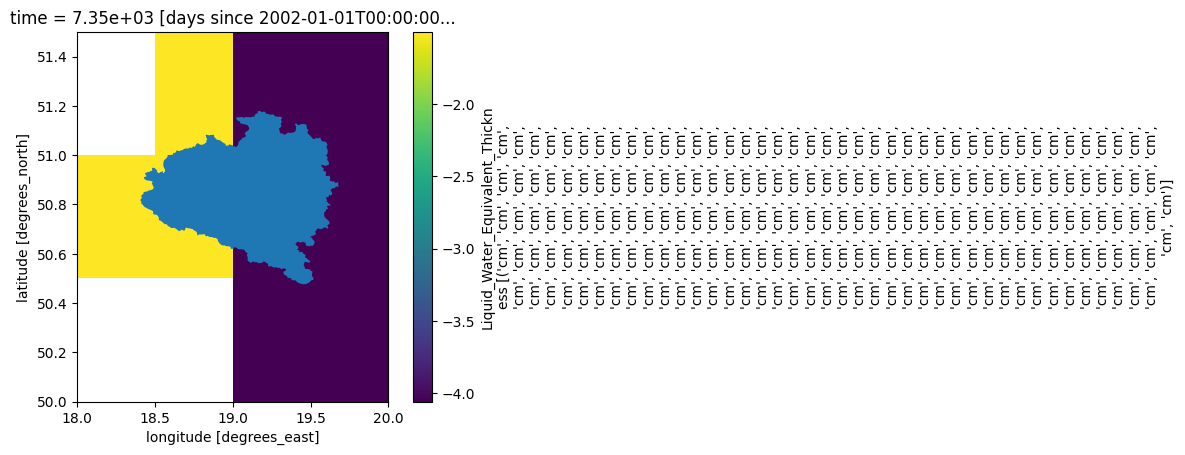

In [9]:
#plot last tif
ax = plt.gca()
lwe.plot(ax = ax)
geodf.plot(ax = ax)

In [59]:
lwe

<xarray.DataArray 'lwe_thickness' (y: 3, x: 4)>
array([[        nan, -1.50275193, -4.05685874, -4.05685874],
       [-1.50275193, -1.50275193, -4.05685874, -4.05685874],
       [        nan,         nan, -4.05685874, -4.05685874]])
Coordinates:
    time         float64 7.35e+03
  * x            (x) float64 18.25 18.75 19.25 19.75
  * y            (y) float64 51.25 50.75 50.25
    spatial_ref  int64 0
    WGS84        int64 0
Attributes: (12/27)
    lat#axis:                Y
    lat#bounds:              lat_bounds
    lat#long_name:           latitude
    lat#standard_name:       latitude
    lat#units:               degrees_north
    lat#valid_max:           89.75
    ...                      ...
    units:                   ('cm', 'cm', 'cm', 'cm', 'cm', 'cm', 'cm', 'cm',...
    valid_max:               835.8517406251696
    valid_min:               -1832.249510242914
    scale_factor:            1.0
    add_offset:              0.0
    _FillValue:              -99999.0

In [3]:
ddf = pd.read_pickle("data/grace_df.pickle")

In [5]:
ddf.loc[ddf["date"] == "2012-01-01"]

,date,value
111,2012-01-01,2.8137167414225255
112,2012-01-01,5.714638681574599


In [8]:
ddf.iloc[110:114]

,date,value
110,2011-11-01,-1.3889100575666482
111,2011-12-01,2.8137167414225255
112,2012-01-01,5.714638681574599
113,2012-02-01,5.938801391294287


In [7]:
ddf.iloc[111]["date"] = "2011-12-01"

In [11]:
ddf.iloc[139:150]

,date,value
139,2014-11-01,-4.905530119606048
140,2015-01-01,-0.09869493155804339
141,2015-02-01,0.609931414465957
142,2015-03-01,0.4724614654670116
143,2015-04-01,-1.679140995906674
144,2015-04-01,-1.8184314388454825
145,2015-07-01,-9.315315154392161
146,2015-08-01,-13.548019091764615
147,2015-09-01,-12.941966899992394
148,2015-12-01,-4.448158928975665


In [12]:
ddf.iloc[144]["date"] = "2015-05-01"

In [13]:
ddf.to_pickle("data/grace_df.pickle")